In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Can slow down but ensures determinism

set_seed(42)


import json
import matplotlib.pyplot as plt

from mobilenet import MobileNet
from data import get_train_valid_loader, get_test_loader

In [2]:
def train_func(model, optimizer, criterion, train_loader, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    return train_loss, train_accuracy

def eval(model, criterion, test_loader, device):
    # Evaluate the model on the validation set
    model.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total

    return valid_loss, valid_accuracy


In [3]:
batch_size = 128
data_dir = './data'
train_loader, valid_loader = get_train_valid_loader(data_dir=data_dir,batch_size=batch_size,augment=True,random_seed=42)
test_loader = get_test_loader(data_dir=data_dir, batch_size=batch_size)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
momentum = 0.9


Experiment: Training with weight decay 0.0005 and cosine annealing learning rate and Sigmoid activation
Epoch [1/300], Train Loss: 4.2019, Train Acc: 5.87%, Valid Loss: 3.7928, Valid Acc: 10.31%, Learning Rate: 0.049999
Epoch [11/300], Train Loss: 2.0685, Train Acc: 43.48%, Valid Loss: 2.2771, Valid Acc: 39.91%, Learning Rate: 0.049834
Epoch [21/300], Train Loss: 1.7355, Train Acc: 51.33%, Valid Loss: 2.5756, Valid Acc: 35.85%, Learning Rate: 0.049398
Epoch [31/300], Train Loss: 1.5825, Train Acc: 54.81%, Valid Loss: 2.6603, Valid Acc: 33.23%, Learning Rate: 0.048694
Epoch [41/300], Train Loss: 1.4805, Train Acc: 57.49%, Valid Loss: 2.3324, Valid Acc: 39.91%, Learning Rate: 0.047731
Epoch [51/300], Train Loss: 1.4133, Train Acc: 58.92%, Valid Loss: 2.4246, Valid Acc: 38.60%, Learning Rate: 0.046519
Epoch [61/300], Train Loss: 1.3421, Train Acc: 60.95%, Valid Loss: 2.3166, Valid Acc: 41.95%, Learning Rate: 0.045070
Epoch [71/300], Train Loss: 1.2800, Train Acc: 62.29%, Valid Loss: 2.405

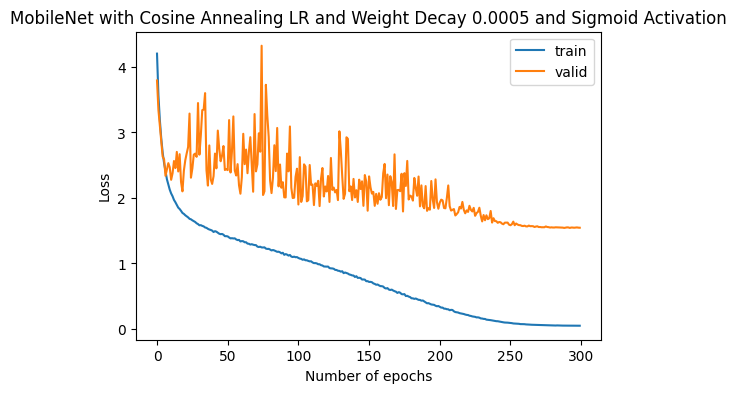

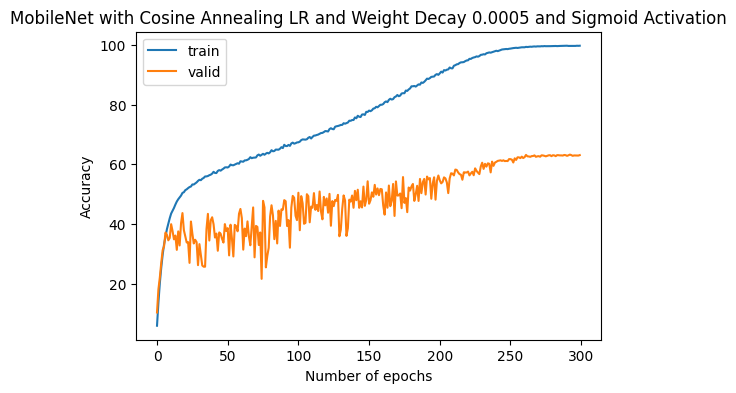

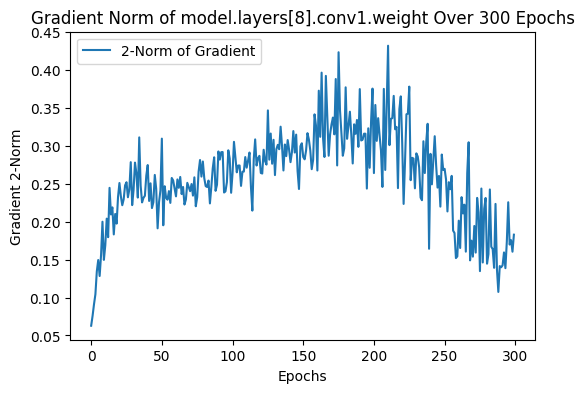

In [6]:
# Hyperparameters for the new experiment
num_epochs = 300
learning_rate = 0.05
weight_decay = 5e-4 # best weight decay from previous experiment

# Function to train with weight decay and cosine annealing learning rate
def train_weight_decay_cosine_annealing(model, initial_lr, weight_decay, criterion, train_loader, valid_loader, device, num_epochs):
    optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    grad_norms = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_func(model, optimizer, criterion, train_loader, device, epoch)
        valid_loss, valid_accuracy = eval(model, criterion, valid_loader, device)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_accuracies.append(train_accuracy)
        valid_accuracies.append(valid_accuracy)

        scheduler.step()
        grad_norm = torch.norm(model.layers[8].conv1.weight.grad, p=2).item()
        grad_norms.append(grad_norm)
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()[0]  # Extract current learning rate
        if epoch % 10 == 0 or epoch == num_epochs-1:
            print(f"Epoch [{epoch+1}/{num_epochs}], "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Train Acc: {train_accuracy:.2f}%, "
                  f"Valid Loss: {valid_loss:.4f}, "
                  f"Valid Acc: {valid_accuracy:.2f}%, "
                  f"Learning Rate: {current_lr:.6f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies, grad_norms
    
# Experiment: Train for 300 epochs with weight decay and cosine annealing learning rate
# MobileNet model
def test_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy



model = MobileNet(num_classes=100, sigmoid_block_ind = [4,5,6,7,8,9,10]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

print(f"Experiment: Training with weight decay {weight_decay} and cosine annealing learning rate and Sigmoid activation")
train_losses, valid_losses, train_accuracies, valid_accuracies, grad_norms = train_weight_decay_cosine_annealing(
    model, learning_rate, weight_decay, criterion, train_loader, valid_loader, device, num_epochs)

# Calculate accuracy on the test set
test_acc = test_accuracy(model, test_loader, device)
print(f"Accuracy of the model on the hold-out test set: {test_acc:.2f}%")

plt.figure(figsize=(6, 4))
plt.plot(range(len(train_losses)), train_losses)
plt.plot(range(len(valid_losses)), valid_losses)
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title(f"MobileNet with Cosine Annealing LR and Weight Decay {weight_decay} and Sigmoid Activation")
plt.legend(['train', 'valid'])
plt.savefig(f'images/cosine_annealing_weight_decay_{weight_decay}_sigmoid_loss.png')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(len(train_accuracies)), train_accuracies)
plt.plot(range(len(valid_accuracies)), valid_accuracies)
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title(f"MobileNet with Cosine Annealing LR and Weight Decay {weight_decay} and Sigmoid Activation")
plt.legend(['train', 'valid'])
plt.savefig(f'images/cosine_annealing_weight_decay_{weight_decay}_sigmoid_accuracy.png')
plt.show()

# Plot gradient norm over epochs
plt.figure(figsize=(6, 4))
plt.plot(range(num_epochs), grad_norms, label="2-Norm of Gradient")
plt.xlabel("Epochs")
plt.ylabel("Gradient 2-Norm")
plt.title("Gradient Norm of model.layers[8].conv1.weight Over 300 Epochs")
plt.legend()
# plt.grid()
plt.savefig(f'images/cosine_annealing_weight_decay_{weight_decay}_sigmoid_grad_norm.png')

plt.show()

learning_curves = {"train_losses": train_losses,
                                "valid_losses": valid_losses,
                                "train_accuracies": train_accuracies,
                                "valid_accuracies": valid_accuracies,
                                "grad_norms": grad_norms
                                    }
with open(f'learning_curves/cosine_annealing_weight_decay_{weight_decay}_sigmoid.json', 'w') as fp:
    json.dump(learning_curves, fp)

In [ ]:
!git add .
!git commit -m "Auto-commit after activation function experiment"
!git push origin main  # Change "main" to your branch name